**YOUR NAMES HERE**

Fall 2023

CS 343: Neural Networks

In [5]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

# for obtaining the STL-dataset
import load_stl10_dataset

# for preprocessing dataset
import preprocess_data

# Set the color style so that Professor Layton can see your plots
plt.show()
plt.style.use(['seaborn-v0_8-colorblind', 'seaborn-v0_8-darkgrid'])
# Make the font size larger
plt.rcParams.update({'font.size': 20})

# Turn off scientific notation when printing
np.set_printoptions(suppress=True, precision=3)

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Project 2 | Multi-layer Perceptrons

In this project, you will implement Multilayer Perception (MLP) networks to classify image data belonging to one of 10 classes from the STL-10 dataset. 

You will create two networks that use the softmax activation function and cross-entropy loss: 

- One without a hidden layer (**Task 2**; `softmax_layer.ipynb`) and 
- One with a hidden layer (**Task 3**; ``mlp.ipynb``)

That is, before you implement the MLP with hidden layer, you will create a simpler single layer network (similar architecture to ADALINE) to test your loss and activation function code.

You will get experience working with:

- a large "real" image dataset
- batch vs stochastic training
- regularization
- multi-class data classification
- network weight visualization

## Task 1: Download and preprocess datasets

### STL-10

More info: https://cs.stanford.edu/~acoates/stl10/

**Properties:**
- 10 images classes: airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck
- 5000 images.
- 96x96 resolution (we will work with them converted to 32x32 for rapid development and debugging purposes)

### 1a. Download the STL-10 dataset, convert to 32x32 images

This data acquistion script should "just work". You're welcome to take a peek at the script to see where the data is going, but you shouldn't need to tinker with it. It needs to download the dataset from the internet, which might take a few minutes depending on your internet speed. I set up the script so that it caches the dataset locally in your project folder, so you should only need to download it once. There is a progress percentage indicator.

You should see the following output:

```
Downloading stl10_binary.tar.gz 100.00%Downloaded stl10_binary.tar.gz
Extracting ./data/stl10_binary.tar.gz...Done!
Images are: (5000, 96, 96, 3)
Labels are: (5000,)
Resizing 5000 images to 32x32...Done!
Saving Numpy arrays the images and labels to ./numpy...Done!
```

*Note: If the download is taking too long, use [this Google Drive link](https://drive.google.com/file/d/1vGpaYOFU1WhgDBLcSjWDy7hC5XgHJQoq/view?usp=sharing) to obtain the dataset (`stl10_binary.tar.gz`). Once the download finishes, place `stl10_binary.tar.gz` in a subfolder called `data` in your Project 2 working directory. Then when running the cell below, the `load_stl10_dataset` script should detect the file and resume its job in preprocessing the data and giving you the images and labels.*

In [2]:
# Download the dataset from the internet, convert it to Numpy ndarray, resize to 32x32
# cache it locally on your computer for faster loading next time.
stl_imgs, stl_labels = load_stl10_dataset.load()

Extracting ./data/stl10_binary.tar.gz...Done!
Images are: (5000, 96, 96, 3)
Labels are: (5000,)
Resizing 5000 images to 32x32...Done!
Saving Numpy arrays the images and labels to ./numpy...Done!


### 1b. Take a look at a sample of the images and their associated classes in the dataset

These image-class pairs are what you will train your network on.

In the cell below, create a 5x5 plot showing 25 **randomly selected** images from the dataset. Label each image with its associated class. An example output is included below (*your image will differ due to randomness*). **Do a sanity check!** Does the class look correct for each image?

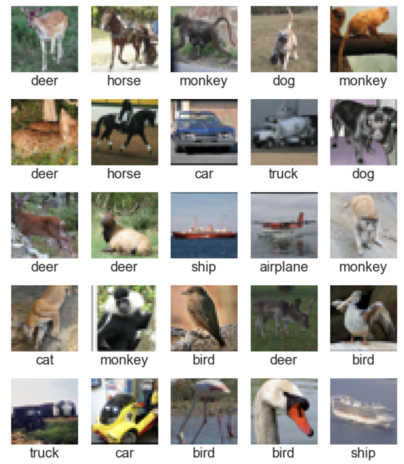

In [18]:
# Load in the string names for each class
labels = np.load("numpy/labels.npy")
images = np.load("numpy/images.npy")
labels.shape

(5000,)

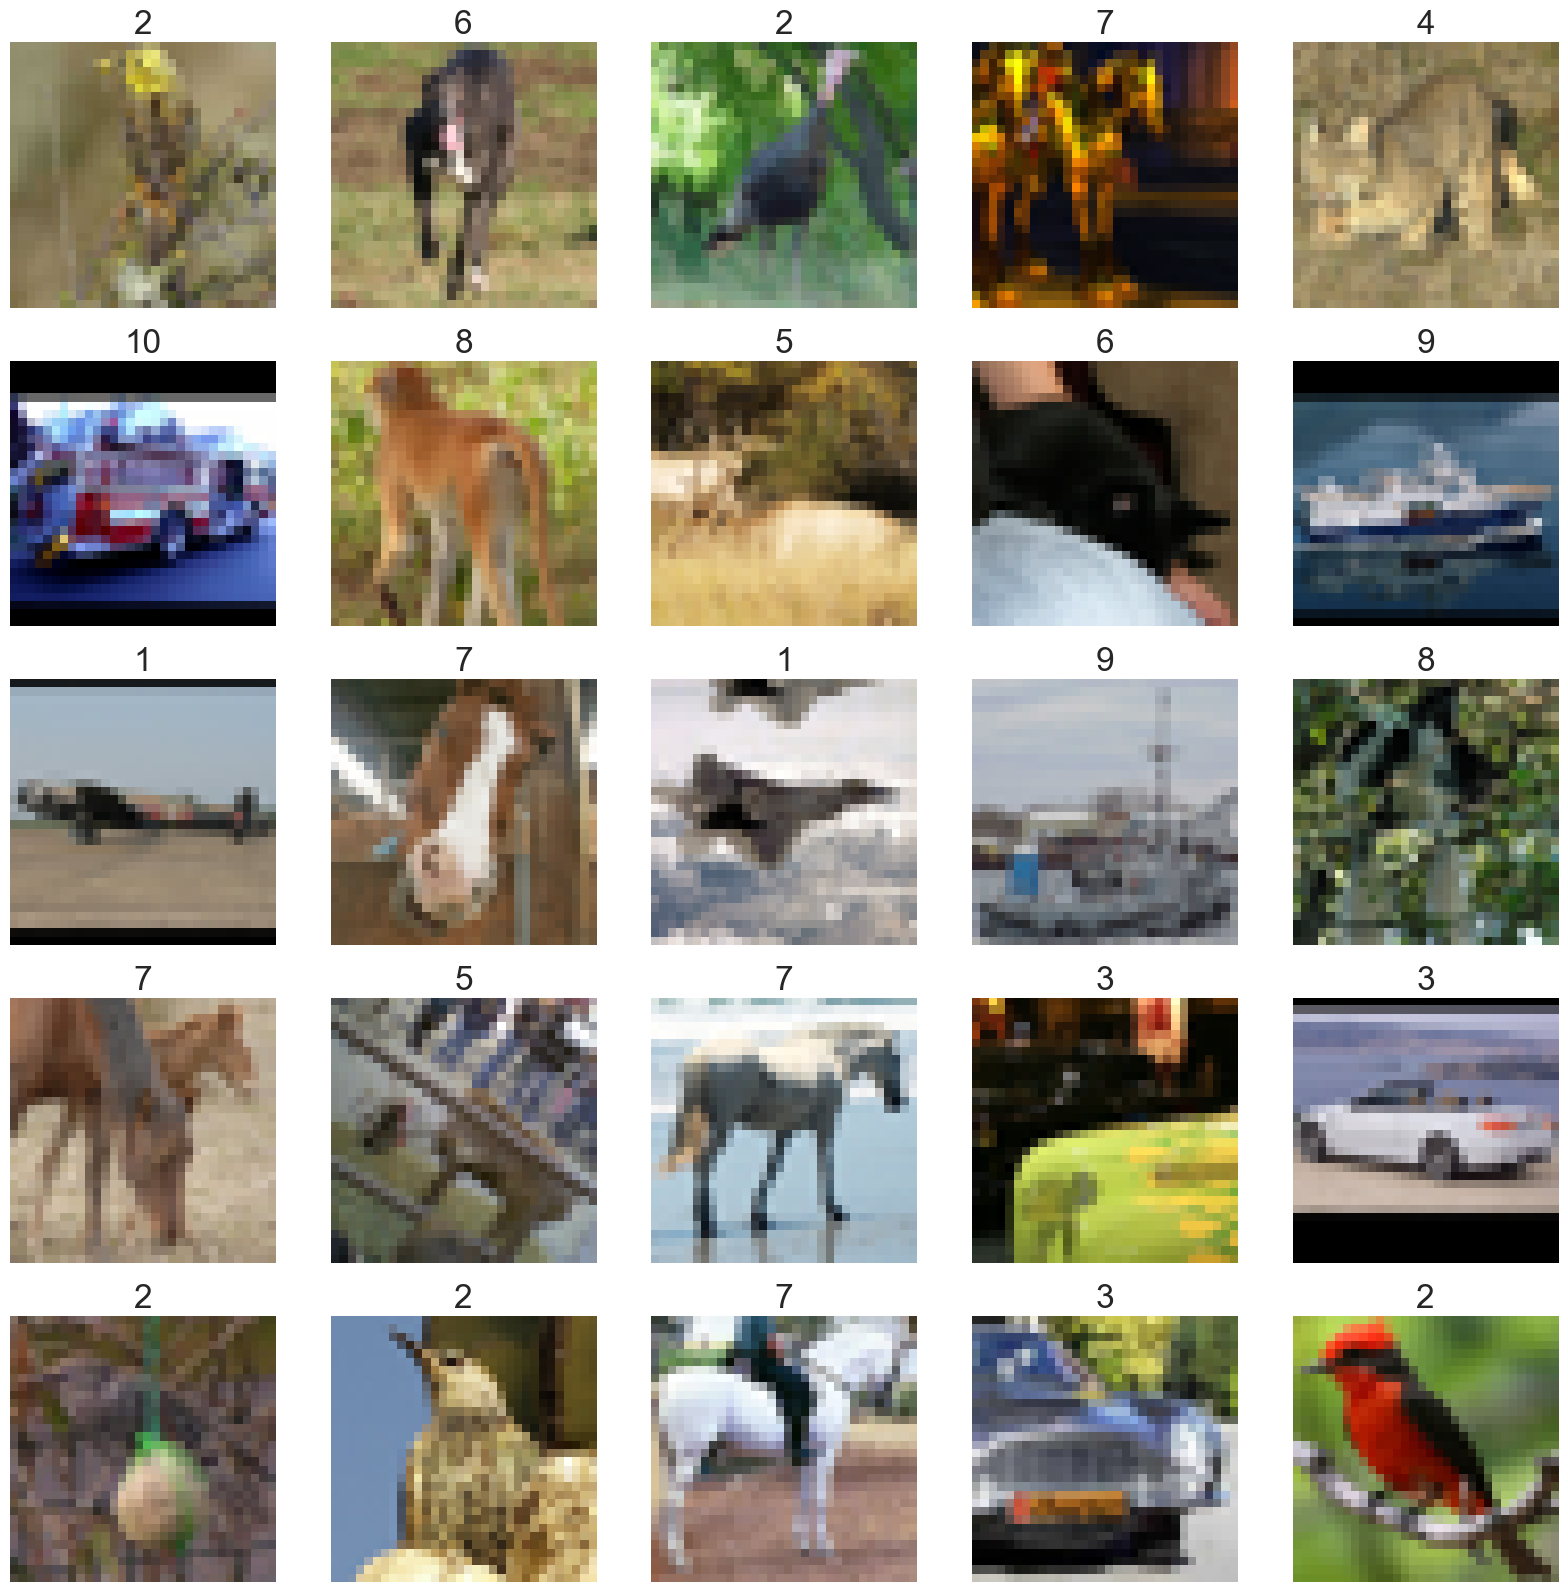

In [21]:
# Your 5x5 image grid plotting code here
def image_plot(images, labels):
    '''Create a 5x5 grid of face images
    
    Parameters:
    -----------
    face_imgs: ndarray. shape=(N, img_y, img_x).
        Grayscale images to show.
    face_names: ndarray. shape=(N,).
        Names of the person in each image represented as strings.
    
    TODO:
    - Create a 5x5 grid of plots of a legible size
    - In each plot, show the grayscale image and make the title the person's name.
    '''

    fig, ax = plt.subplots(5,5, figsize= (20,20))
    y = 0
    for i in range(5):
        for x in range(5):
            ax[i,x].imshow(np.squeeze(images[y, :, :]), cmap=plt.get_cmap('gray'))
            ax[i,x].set_title(labels[y])
            ax[i,x].set_xticks([])
            ax[i,x].set_yticks([])
            y+=1
    
image_plot(images,labels)

### 1c. Preprocess the data

Preprocessing data is an important part of working with neural networks. 

Fill in the function `preprocess_stl` in `preprocess_data.py`, implementing the 4 listed goals. Run the below test code to get the desired print out.

In [20]:
# Preprocess image pixel values for the MLP net
stl_imgs_pp, stl_labels_pp = preprocess_data.preprocess_stl(stl_imgs, stl_labels)

# Some values from sample 100
sample100 = np.array([ 1.025,  1.025,  1.179,  1.426,  1.42 ,  1.513,  0.924,  0.97 ,
        1.024, -1.141, -1.162, -1.018, -0.263, -0.317, -0.252,  1.483,
        1.508,  1.511,  1.198,  1.2  ,  1.248,  0.668,  0.677,  0.824,
        0.645])

print(f'stl_imgs dtype is {stl_imgs_pp.dtype} and it should be float64')
print(f'stl_imgs min/max is {np.min(stl_imgs_pp[:, 1:]):.3f}/{np.max(stl_imgs_pp[:, 1:]):.3f} and it should be -2.078/3.043')
print(f'stl_imgs shape is {stl_imgs_pp.shape} and it should be (5000, 3072)')
print(f'stl_labels span {stl_labels_pp.min()}->{stl_labels_pp.max()} and it should be 0->9')
print(f'Your first few feature values from sample (image) 100 is:\n{stl_imgs_pp[99, :25]}\nThey should be:\n{sample100}')

stl_imgs dtype is float64 and it should be float64
stl_imgs min/max is 0.000/255.000 and it should be -2.078/3.043
stl_imgs shape is (5000, 3072) and it should be (5000, 3072)
stl_labels span 1->255 and it should be 0->9
Your first few feature values from sample (image) 100 is:
[175. 180. 190. 205. 210. 217. 170. 178. 180.  21.  23.  22.  85.  85.
  82. 212. 219. 220. 191. 196. 199. 153. 158. 166. 152.]
They should be:
[ 1.025  1.025  1.179  1.426  1.42   1.513  0.924  0.97   1.024 -1.141
 -1.162 -1.018 -0.263 -0.317 -0.252  1.483  1.508  1.511  1.198  1.2
  1.248  0.668  0.677  0.824  0.645]


### 1d. Create train, validation, test, and dev splits

Complete the `create_splits` function in `preprocess_data.py` to divvy up the dataset into train/test/validation/development subsets. You should obtain a printout as follows:

```
Train data shape:  (3500, 3072)
Train labels shape:  (3500,)
Test data shape:  (500, 3072)
Test labels shape:  (500,)
Validation data shape:  (500, 3072)
Validation labels shape:  (500,)
dev data shape:  (500, 3072)
dev labels shape:  (500,)
```

In [ ]:
x_train, y_train, x_test, y_test, x_val, y_val, x_dev, y_dev = preprocess_data.create_splits(stl_imgs_pp, stl_labels_pp)  

print ('Train data shape: ', x_train.shape)
print ('Train labels shape: ', y_train.shape)
print ('Test data shape: ', x_test.shape)
print ('Test labels shape: ', y_test.shape)
print ('Validation data shape: ', x_val.shape)
print ('Validation labels shape: ', y_val.shape)
print ('dev data shape: ', x_dev.shape)
print ('dev labels shape: ', y_dev.shape)

### 1e. Automate loading and preprocessing STL-10

Complete the `load_stl10` function in `preprocess_data.py` to assemble all the above preprocessing steps into one function. You can (selectively) copy and paste! You should obtain a printout as follows:

```
Found cached numpy arrays the images and labels. Loading them...
Images are: (5000, 32, 32, 3)
Labels are: (5000,)
Train data shape:  (3000, 3072)
Train labels shape:  (3000,)
Test data shape:  (750, 3072)
Test labels shape:  (750,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
dev data shape:  (250, 3072)
dev labels shape:  (250,)
```

**Note:** The below test code uses a different split to help exercise your code.

In [ ]:
x_train, y_train, x_test, y_test, x_val, y_val, x_dev, y_dev = preprocess_data.load_stl10(n_train_samps=3000, n_test_samps=750, n_valid_samps=1000, n_dev_samps=250)

print ('Train data shape: ', x_train.shape)
print ('Train labels shape: ', y_train.shape)
print ('Test data shape: ', x_test.shape)
print ('Test labels shape: ', y_test.shape)
print ('Validation data shape: ', x_val.shape)
print ('Validation labels shape: ', y_val.shape)
print ('dev data shape: ', x_dev.shape)
print ('dev labels shape: ', y_dev.shape)